<a href="https://colab.research.google.com/github/LegendofApple/FinalProjectReport/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
lr = 0.0002
num_epochs = 20
latent_size = 100
image_channels = 1
image_size = 64

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

mnist_data = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

# Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, image_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(image_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

d_losses = []
g_losses = []
accuracies = []

# Training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        real_images = images.to(device)
        batch_size = real_images.size()[0]
        real_labels = torch.ones(batch_size, 1, 1, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1, 1, 1).to(device)

        # Train discriminator
        optimizer_D.zero_grad()
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)

        z = torch.randn(batch_size, latent_size, 1, 1).to(device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        # Calculate accuracy
        real_accuracy = torch.mean((real_outputs > 0.5).float()).item()
        fake_accuracy = torch.mean((fake_outputs < 0.5).float()).item()
        total_accuracy = (real_accuracy + fake_accuracy) / 2

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        accuracies.append(total_accuracy)

        # Print losses and accuracy
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], '
                  f'D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}, '
                  f'Accuracy: {total_accuracy:.4f}')
        
        # Save generated images
        if (epoch + 1) % 5 == 0:
          fake_images = vutils.make_grid(fake_images, padding=2, normalize=True)
          vutils.save_image(fake_images, f'fake_images_epoch_{epoch+1}.png')

Epoch [1/20], Step [100/469], D_loss: 0.0020, G_loss: 8.1306, Accuracy: 1.0000
Epoch [1/20], Step [200/469], D_loss: 8.1781, G_loss: 23.6623, Accuracy: 0.7383
Epoch [1/20], Step [300/469], D_loss: 0.3750, G_loss: 5.2229, Accuracy: 1.0000
Epoch [1/20], Step [400/469], D_loss: 0.3038, G_loss: 2.6137, Accuracy: 0.9961
Epoch [2/20], Step [100/469], D_loss: 0.8864, G_loss: 2.5092, Accuracy: 0.9922
Epoch [2/20], Step [200/469], D_loss: 0.9926, G_loss: 1.0133, Accuracy: 0.6367
Epoch [2/20], Step [300/469], D_loss: 1.1624, G_loss: 0.3409, Accuracy: 0.1484
Epoch [2/20], Step [400/469], D_loss: 0.5498, G_loss: 1.7739, Accuracy: 0.9297
Epoch [3/20], Step [100/469], D_loss: 0.7606, G_loss: 1.5395, Accuracy: 0.8633
Epoch [3/20], Step [200/469], D_loss: 0.7710, G_loss: 2.1451, Accuracy: 0.9219
Epoch [3/20], Step [300/469], D_loss: 0.6977, G_loss: 1.3672, Accuracy: 0.7539
Epoch [3/20], Step [400/469], D_loss: 2.2419, G_loss: 1.3255, Accuracy: 0.4805
Epoch [4/20], Step [100/469], D_loss: 0.3810, G_los

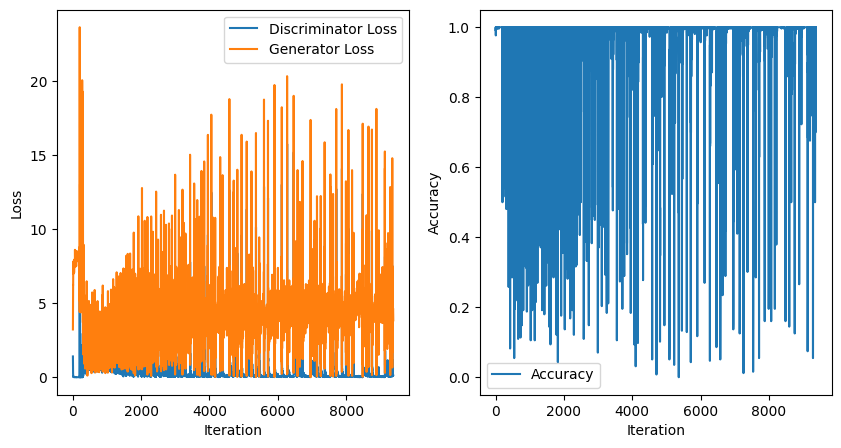

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

plt.show()